In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from prettytable import PrettyTable


In [66]:
class CNNModel(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8 * 32 * 32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv_layer(x)
        # Flatten
        x = torch.flatten(x, start_dim=1)
        # Fully connected layers
        x = self.fc_layer(x)
        return x
    

class ImageDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

params_dict = {
		'macrophage_max_recruitment_rate': [0,8e-9],
		'macrophage_recruitment_min_signal': [0,0.2],
		'macrophage_recruitment_saturation_signal': [0,0.6],
		'DC_max_recruitment_rate': [0,4e-9],
		'DC_recruitment_min_signal': [0,0.2],
		'DC_recruitment_saturation_signal': [0,0.6],
		'DC_leave_rate': [0,0.4],
		'Th1_decay': [0,2.8e-6],
		'T_Cell_Recruitment': [0,2.2e-4],
		'DM_decay': [0,7e-4]
}

data_layers = [
    'activated_TNF_secretion_rate',
    'activated_immune_cell',
    'cell_type_CD4_Tcell',
    'cell_type_CD8_Tcell',
    'cell_type_DC',
    'cell_type_cancer_cell',
    'cell_type_lung_cell',
    'cell_type_macrophage',
    'current_phase_G0G1_phase',
    'current_phase_G2_phase',
    'current_phase_M_phaseapoptotic',
    'current_phase_S_phase',
    'debris_secretion_rate',
    'nuclear_volume',
    'sensitivity_to_TNF_chemotaxis',
    'sensitivity_to_debris_chemotaxis',
    'total_volume',
    'TNF',
    'debris'
]

In [3]:
param_ranges = torch.tensor([x[1] - x[0] for x in params_dict.values()])

In [4]:
param_ranges

tensor([8.0000e-09, 2.0000e-01, 6.0000e-01, 4.0000e-09, 2.0000e-01, 6.0000e-01,
        4.0000e-01, 2.8000e-06, 2.2000e-04, 7.0000e-04])

In [25]:
data = np.load('../dl_data/100_data.npy')
Theta = np.load('../dl_data/theta.npy')
data = np.transpose(data, (0, 3, 1, 2))
L, H, W = data.shape[1], data.shape[2], data.shape[3]
B = data.shape[0]
T = Theta.shape[1]

data = torch.tensor(data, dtype=torch.float32)
Theta = torch.tensor(Theta, dtype=torch.float32)

In [26]:
Theta

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.0000e-09, 1.0000e-01, 3.0000e-01,  ..., 1.4000e-06, 1.1000e-04,
         3.5000e-04],
        [6.0000e-09, 5.0000e-02, 1.5000e-01,  ..., 2.1000e-06, 1.6500e-04,
         5.2500e-04],
        ...,
        [6.0313e-09, 1.4922e-01, 3.1172e-01,  ..., 2.5922e-06, 1.5211e-04,
         4.2383e-04],
        [4.0313e-09, 9.9219e-02, 1.6172e-01,  ..., 1.8922e-06, 2.0711e-04,
         5.9883e-04],
        [3.1250e-11, 1.9922e-01, 4.6172e-01,  ..., 4.9219e-07, 9.7109e-05,
         2.4883e-04]])

In [27]:
# Define parameters
input_channels = L  # Number of channels in images
output_dim = T      # Number of outputs in Theta
num_epochs = 100

In [32]:
# Instantiate the model
model = CNNModel(input_channels=input_channels, output_dim=output_dim)

# Define loss and optimizer
criterion = nn.MSELoss()  # Use a suitable loss function, e.g., MSE for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv_layer): Sequential(
    (0): Conv2d(19, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [33]:
def fw_hook(module, input, output):
    print(f"Shape of output from {module} is {output.shape}.")


# Any tensor created within this torch.device context manager will be
# on the meta device.
with torch.device("meta"):
    net = CNNModel(input_channels=input_channels, output_dim=output_dim)
    inp = torch.randn((256, L, H, W))

for name, layer in net.named_modules():
    layer.register_forward_hook(fw_hook)

out = net(inp)

Shape of output from Conv2d(19, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) is torch.Size([256, 16, 128, 128]).
Shape of output from BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) is torch.Size([256, 16, 128, 128]).
Shape of output from ReLU() is torch.Size([256, 16, 128, 128]).
Shape of output from MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is torch.Size([256, 16, 64, 64]).
Shape of output from Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) is torch.Size([256, 8, 64, 64]).
Shape of output from BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) is torch.Size([256, 8, 64, 64]).
Shape of output from ReLU() is torch.Size([256, 8, 64, 64]).
Shape of output from MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is torch.Size([256, 8, 32, 32]).
Shape of output from Sequential(
  (0): Conv2d(19, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [34]:
transform = transforms.Compose([
    # transforms.ToTensor(),  # Convert image to tensor
	transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to range [-1, 1]
    transforms.RandomRotation(degrees=30),  # Rotate randomly within ±30 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally with 50% probability
    transforms.RandomVerticalFlip(p=0.5),  # Flip vertically with 50% probability
    # transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),  # Random crop and resize
])

dataset = ImageDataset(data, Theta, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify the split
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 204
Validation dataset size: 52


In [35]:
device

device(type='mps')

In [61]:
# Training loop (simplified)
validation_loss = []
training_loss = []
param_ranges = param_ranges.to(device)
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        model.train()
        for input, target in tepoch:
            optimizer.zero_grad()
            input = input.to(device)
            target = target.to(device)

            target = target / param_ranges
            outputs = model(input)

            loss = criterion(outputs, target) 
            loss.backward()  # Backward pass
            optimizer.step()

            # Accumulate metrics
            epoch_loss += loss.item()
            num_batches += 1
            
            # Update tqdm bar
            tepoch.set_postfix(batch_loss=loss.item())
        training_loss.append(epoch_loss / num_batches)

        # Validation loop
        epoch_loss = 0.0
        num_batches = 0
        model.eval()
        with torch.no_grad():
            for input, target in val_loader:
                input = input.to(device)
                target = target.to(device)
                target = target / param_ranges

                output = model(input)

                loss = criterion(output, target)
                epoch_loss += loss.item()
                num_batches += 1
        validation_loss.append(epoch_loss / num_batches)
    # Epoch-level metrics
    avg_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average  Val Loss: {avg_loss:.4f}")

100%|██████████| 7/7 [00:00<00:00, 11.79batch/s, batch_loss=0.0561]


Epoch 1 completed. Average  Val Loss: 0.1023


100%|██████████| 7/7 [00:00<00:00, 13.94batch/s, batch_loss=0.0613]


Epoch 2 completed. Average  Val Loss: 0.0992


100%|██████████| 7/7 [00:00<00:00, 13.37batch/s, batch_loss=0.0612]


Epoch 3 completed. Average  Val Loss: 0.1027


100%|██████████| 7/7 [00:00<00:00, 12.82batch/s, batch_loss=0.0554]


Epoch 4 completed. Average  Val Loss: 0.1020


100%|██████████| 7/7 [00:00<00:00, 13.60batch/s, batch_loss=0.0697]


Epoch 5 completed. Average  Val Loss: 0.1086


100%|██████████| 7/7 [00:00<00:00, 13.75batch/s, batch_loss=0.0683]


Epoch 6 completed. Average  Val Loss: 0.1065


100%|██████████| 7/7 [00:00<00:00, 14.99batch/s, batch_loss=0.0685]


Epoch 7 completed. Average  Val Loss: 0.1039


100%|██████████| 7/7 [00:00<00:00, 14.20batch/s, batch_loss=0.0624]


Epoch 8 completed. Average  Val Loss: 0.1102


100%|██████████| 7/7 [00:00<00:00, 15.12batch/s, batch_loss=0.0677]


Epoch 9 completed. Average  Val Loss: 0.1218


100%|██████████| 7/7 [00:00<00:00, 13.58batch/s, batch_loss=0.0685]


Epoch 10 completed. Average  Val Loss: 0.1161


100%|██████████| 7/7 [00:00<00:00, 14.95batch/s, batch_loss=0.0741]


Epoch 11 completed. Average  Val Loss: 0.1209


100%|██████████| 7/7 [00:00<00:00, 14.77batch/s, batch_loss=0.0607]


Epoch 12 completed. Average  Val Loss: 0.1321


100%|██████████| 7/7 [00:00<00:00, 14.21batch/s, batch_loss=0.0638]


Epoch 13 completed. Average  Val Loss: 0.1126


100%|██████████| 7/7 [00:00<00:00, 13.87batch/s, batch_loss=0.0864]


Epoch 14 completed. Average  Val Loss: 0.1108


100%|██████████| 7/7 [00:00<00:00, 12.64batch/s, batch_loss=0.0479]


Epoch 15 completed. Average  Val Loss: 0.1043


100%|██████████| 7/7 [00:00<00:00, 14.71batch/s, batch_loss=0.0538]


Epoch 16 completed. Average  Val Loss: 0.1043


100%|██████████| 7/7 [00:00<00:00, 14.73batch/s, batch_loss=0.0801]


Epoch 17 completed. Average  Val Loss: 0.0955


100%|██████████| 7/7 [00:00<00:00, 14.54batch/s, batch_loss=0.0592]


Epoch 18 completed. Average  Val Loss: 0.1090


100%|██████████| 7/7 [00:00<00:00, 14.87batch/s, batch_loss=0.0572]


Epoch 19 completed. Average  Val Loss: 0.1113


100%|██████████| 7/7 [00:00<00:00, 14.62batch/s, batch_loss=0.0603]


Epoch 20 completed. Average  Val Loss: 0.1080


100%|██████████| 7/7 [00:00<00:00, 13.04batch/s, batch_loss=0.0605]


Epoch 21 completed. Average  Val Loss: 0.1038


100%|██████████| 7/7 [00:00<00:00, 14.70batch/s, batch_loss=0.0491]


Epoch 22 completed. Average  Val Loss: 0.1073


100%|██████████| 7/7 [00:00<00:00, 14.73batch/s, batch_loss=0.0578]


Epoch 23 completed. Average  Val Loss: 0.1077


100%|██████████| 7/7 [00:00<00:00, 13.29batch/s, batch_loss=0.0691]


Epoch 24 completed. Average  Val Loss: 0.1062


100%|██████████| 7/7 [00:00<00:00, 12.73batch/s, batch_loss=0.0548]


Epoch 25 completed. Average  Val Loss: 0.1143


100%|██████████| 7/7 [00:00<00:00, 14.64batch/s, batch_loss=0.0695]


Epoch 26 completed. Average  Val Loss: 0.1229


100%|██████████| 7/7 [00:00<00:00, 14.76batch/s, batch_loss=0.0689]


Epoch 27 completed. Average  Val Loss: 0.1085


100%|██████████| 7/7 [00:00<00:00, 14.41batch/s, batch_loss=0.0577]


Epoch 28 completed. Average  Val Loss: 0.1137


100%|██████████| 7/7 [00:00<00:00, 13.44batch/s, batch_loss=0.0641]


Epoch 29 completed. Average  Val Loss: 0.1071


100%|██████████| 7/7 [00:00<00:00, 14.56batch/s, batch_loss=0.0675]


Epoch 30 completed. Average  Val Loss: 0.1058


100%|██████████| 7/7 [00:00<00:00, 14.46batch/s, batch_loss=0.069] 


Epoch 31 completed. Average  Val Loss: 0.1082


100%|██████████| 7/7 [00:00<00:00, 13.98batch/s, batch_loss=0.0503]


Epoch 32 completed. Average  Val Loss: 0.1112


100%|██████████| 7/7 [00:00<00:00, 14.05batch/s, batch_loss=0.0655]


Epoch 33 completed. Average  Val Loss: 0.1116


100%|██████████| 7/7 [00:00<00:00, 14.42batch/s, batch_loss=0.0555]


Epoch 34 completed. Average  Val Loss: 0.1153


100%|██████████| 7/7 [00:00<00:00, 14.62batch/s, batch_loss=0.0545]


Epoch 35 completed. Average  Val Loss: 0.1134


100%|██████████| 7/7 [00:00<00:00, 12.98batch/s, batch_loss=0.0517]


Epoch 36 completed. Average  Val Loss: 0.1189


100%|██████████| 7/7 [00:00<00:00, 14.49batch/s, batch_loss=0.0543]


Epoch 37 completed. Average  Val Loss: 0.1063


100%|██████████| 7/7 [00:00<00:00, 14.92batch/s, batch_loss=0.073] 


Epoch 38 completed. Average  Val Loss: 0.1094


100%|██████████| 7/7 [00:00<00:00, 13.44batch/s, batch_loss=0.0633]


Epoch 39 completed. Average  Val Loss: 0.1140


100%|██████████| 7/7 [00:00<00:00, 13.67batch/s, batch_loss=0.0794]


Epoch 40 completed. Average  Val Loss: 0.1233


100%|██████████| 7/7 [00:00<00:00, 12.74batch/s, batch_loss=0.0522]


Epoch 41 completed. Average  Val Loss: 0.1097


100%|██████████| 7/7 [00:00<00:00, 14.56batch/s, batch_loss=0.0454]


Epoch 42 completed. Average  Val Loss: 0.1158


100%|██████████| 7/7 [00:00<00:00, 14.07batch/s, batch_loss=0.0709]


Epoch 43 completed. Average  Val Loss: 0.1079


100%|██████████| 7/7 [00:00<00:00, 13.88batch/s, batch_loss=0.0576]


Epoch 44 completed. Average  Val Loss: 0.1076


100%|██████████| 7/7 [00:00<00:00, 13.36batch/s, batch_loss=0.0681]


Epoch 45 completed. Average  Val Loss: 0.1125


100%|██████████| 7/7 [00:00<00:00, 12.13batch/s, batch_loss=0.0503]


Epoch 46 completed. Average  Val Loss: 0.1074


100%|██████████| 7/7 [00:00<00:00, 13.30batch/s, batch_loss=0.0567]


Epoch 47 completed. Average  Val Loss: 0.1085


100%|██████████| 7/7 [00:00<00:00, 13.87batch/s, batch_loss=0.0598]


Epoch 48 completed. Average  Val Loss: 0.1120


100%|██████████| 7/7 [00:00<00:00, 14.33batch/s, batch_loss=0.0581]


Epoch 49 completed. Average  Val Loss: 0.1105


100%|██████████| 7/7 [00:00<00:00, 14.99batch/s, batch_loss=0.0516]


Epoch 50 completed. Average  Val Loss: 0.1195


100%|██████████| 7/7 [00:00<00:00, 13.42batch/s, batch_loss=0.0518]


Epoch 51 completed. Average  Val Loss: 0.1093


100%|██████████| 7/7 [00:00<00:00, 13.67batch/s, batch_loss=0.0477]


Epoch 52 completed. Average  Val Loss: 0.1111


100%|██████████| 7/7 [00:00<00:00, 13.87batch/s, batch_loss=0.0425]


Epoch 53 completed. Average  Val Loss: 0.1105


100%|██████████| 7/7 [00:00<00:00, 14.87batch/s, batch_loss=0.0331]


Epoch 54 completed. Average  Val Loss: 0.1115


100%|██████████| 7/7 [00:00<00:00, 14.47batch/s, batch_loss=0.0505]


Epoch 55 completed. Average  Val Loss: 0.1083


100%|██████████| 7/7 [00:00<00:00, 13.29batch/s, batch_loss=0.0479]


Epoch 56 completed. Average  Val Loss: 0.1100


100%|██████████| 7/7 [00:00<00:00, 12.49batch/s, batch_loss=0.0596]


Epoch 57 completed. Average  Val Loss: 0.1084


100%|██████████| 7/7 [00:00<00:00, 14.83batch/s, batch_loss=0.0615]


Epoch 58 completed. Average  Val Loss: 0.1292


100%|██████████| 7/7 [00:00<00:00, 14.96batch/s, batch_loss=0.0642]


Epoch 59 completed. Average  Val Loss: 0.1079


100%|██████████| 7/7 [00:00<00:00, 13.97batch/s, batch_loss=0.0609]


Epoch 60 completed. Average  Val Loss: 0.1090


100%|██████████| 7/7 [00:00<00:00, 14.09batch/s, batch_loss=0.061] 


Epoch 61 completed. Average  Val Loss: 0.1099


100%|██████████| 7/7 [00:00<00:00, 13.73batch/s, batch_loss=0.0445]


Epoch 62 completed. Average  Val Loss: 0.1095


100%|██████████| 7/7 [00:00<00:00, 14.63batch/s, batch_loss=0.0538]


Epoch 63 completed. Average  Val Loss: 0.1178


100%|██████████| 7/7 [00:00<00:00, 14.27batch/s, batch_loss=0.0658]


Epoch 64 completed. Average  Val Loss: 0.1136


100%|██████████| 7/7 [00:00<00:00, 14.45batch/s, batch_loss=0.0529]


Epoch 65 completed. Average  Val Loss: 0.1129


100%|██████████| 7/7 [00:00<00:00, 14.35batch/s, batch_loss=0.06]  


Epoch 66 completed. Average  Val Loss: 0.1157


100%|██████████| 7/7 [00:00<00:00, 14.28batch/s, batch_loss=0.0607]


Epoch 67 completed. Average  Val Loss: 0.0998


100%|██████████| 7/7 [00:00<00:00, 14.11batch/s, batch_loss=0.0514]


Epoch 68 completed. Average  Val Loss: 0.1109


100%|██████████| 7/7 [00:00<00:00, 14.44batch/s, batch_loss=0.0505]


Epoch 69 completed. Average  Val Loss: 0.1116


100%|██████████| 7/7 [00:00<00:00, 13.68batch/s, batch_loss=0.0584]


Epoch 70 completed. Average  Val Loss: 0.1148


100%|██████████| 7/7 [00:00<00:00, 14.40batch/s, batch_loss=0.0495]


Epoch 71 completed. Average  Val Loss: 0.1143


100%|██████████| 7/7 [00:00<00:00, 13.85batch/s, batch_loss=0.0598]


Epoch 72 completed. Average  Val Loss: 0.1125


100%|██████████| 7/7 [00:00<00:00, 12.40batch/s, batch_loss=0.049] 


Epoch 73 completed. Average  Val Loss: 0.1144


100%|██████████| 7/7 [00:00<00:00, 12.73batch/s, batch_loss=0.0529]


Epoch 74 completed. Average  Val Loss: 0.1075


100%|██████████| 7/7 [00:00<00:00, 13.22batch/s, batch_loss=0.0741]


Epoch 75 completed. Average  Val Loss: 0.1092


100%|██████████| 7/7 [00:00<00:00, 12.23batch/s, batch_loss=0.057] 


Epoch 76 completed. Average  Val Loss: 0.1113


100%|██████████| 7/7 [00:00<00:00, 13.32batch/s, batch_loss=0.0577]


Epoch 77 completed. Average  Val Loss: 0.1101


100%|██████████| 7/7 [00:00<00:00, 14.57batch/s, batch_loss=0.0535]


Epoch 78 completed. Average  Val Loss: 0.1136


100%|██████████| 7/7 [00:00<00:00, 13.09batch/s, batch_loss=0.0518]


Epoch 79 completed. Average  Val Loss: 0.1136


100%|██████████| 7/7 [00:00<00:00, 14.69batch/s, batch_loss=0.0604]


Epoch 80 completed. Average  Val Loss: 0.1146


100%|██████████| 7/7 [00:00<00:00, 13.53batch/s, batch_loss=0.0481]


Epoch 81 completed. Average  Val Loss: 0.1078


100%|██████████| 7/7 [00:00<00:00, 13.90batch/s, batch_loss=0.0696]


Epoch 82 completed. Average  Val Loss: 0.1155


100%|██████████| 7/7 [00:00<00:00, 14.08batch/s, batch_loss=0.0458]


Epoch 83 completed. Average  Val Loss: 0.1214


100%|██████████| 7/7 [00:00<00:00, 14.52batch/s, batch_loss=0.0431]


Epoch 84 completed. Average  Val Loss: 0.1324


100%|██████████| 7/7 [00:00<00:00, 14.70batch/s, batch_loss=0.0475]


Epoch 85 completed. Average  Val Loss: 0.1120


100%|██████████| 7/7 [00:00<00:00, 14.13batch/s, batch_loss=0.0574]


Epoch 86 completed. Average  Val Loss: 0.1231


100%|██████████| 7/7 [00:00<00:00, 12.61batch/s, batch_loss=0.0484]


Epoch 87 completed. Average  Val Loss: 0.1153


100%|██████████| 7/7 [00:00<00:00, 13.47batch/s, batch_loss=0.0411]


Epoch 88 completed. Average  Val Loss: 0.1190


100%|██████████| 7/7 [00:00<00:00, 14.66batch/s, batch_loss=0.0556]


Epoch 89 completed. Average  Val Loss: 0.1143


100%|██████████| 7/7 [00:00<00:00, 14.55batch/s, batch_loss=0.0613]


Epoch 90 completed. Average  Val Loss: 0.1068


100%|██████████| 7/7 [00:00<00:00, 14.50batch/s, batch_loss=0.0525]


Epoch 91 completed. Average  Val Loss: 0.1073


100%|██████████| 7/7 [00:00<00:00, 12.06batch/s, batch_loss=0.0535]


Epoch 92 completed. Average  Val Loss: 0.1067


100%|██████████| 7/7 [00:00<00:00, 13.92batch/s, batch_loss=0.0347]


Epoch 93 completed. Average  Val Loss: 0.1205


100%|██████████| 7/7 [00:00<00:00, 13.10batch/s, batch_loss=0.0444]


Epoch 94 completed. Average  Val Loss: 0.1129


100%|██████████| 7/7 [00:00<00:00, 14.42batch/s, batch_loss=0.0528]


Epoch 95 completed. Average  Val Loss: 0.1143


100%|██████████| 7/7 [00:00<00:00, 13.54batch/s, batch_loss=0.0881]


Epoch 96 completed. Average  Val Loss: 0.1229


100%|██████████| 7/7 [00:00<00:00, 13.00batch/s, batch_loss=0.0478]


Epoch 97 completed. Average  Val Loss: 0.1087


100%|██████████| 7/7 [00:00<00:00, 14.51batch/s, batch_loss=0.0464]


Epoch 98 completed. Average  Val Loss: 0.1090


100%|██████████| 7/7 [00:00<00:00, 13.32batch/s, batch_loss=0.0484]


Epoch 99 completed. Average  Val Loss: 0.1157


100%|██████████| 7/7 [00:00<00:00, 14.10batch/s, batch_loss=0.049] 


Epoch 100 completed. Average  Val Loss: 0.1125


In [62]:
model.eval()

# Prepare to store predictions and actual values
predictions_list = []
actuals_list = []
param_ranges = param_ranges.to(device)
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, targets) 
        # Denormalize the outputs
        predictions = outputs * param_ranges
        print(loss.item())
        # print(predictions)
        # Collect predictions and actuals
        predictions_list.extend(predictions.tolist())  # List of vectors
        actuals_list.extend(targets.tolist())  # List of vectors

0.18465149402618408
0.18373703956604004


In [ ]:
# Pretty print results in a stacked format
nms = list(params_dict.keys())
table = PrettyTable(["Index", "Type"] + nms)
percent_diffs = []
for idx, (pred_vec, actual_vec) in enumerate(zip(predictions_list, actuals_list)):
    # Format predictions and actuals as strings
    # percent difference compared to actual
    pred_vec = np.array(pred_vec)
    actual_vec = np.array(actual_vec)
    percent_diff = np.abs((pred_vec - actual_vec) / actual_vec) * 100
    percent_diffs.append(percent_diff)
    # Add rows for predictions and actuals
    # table.add_row([idx, "Prediction"] + [f"{x:.2e}" for x in pred_vec])
    # table.add_row([idx, "Actual"] + [f"{x:.2e}" for x in actual_vec])
    table.add_row([idx, "Percent Difference"] + [f"{x:.2f}%" for x in percent_diff])
    table.add_row(["-"*5, "-"*9] + ["-"*10 for _ in range(len(nms))])  # Separator for better readability

meds = np.median(np.array(percent_diffs),axis=0)
table.add_row(["Median", "Percent Difference"] + [f"{x:.2f}%" for x in meds])
print(table)

+--------+--------------------+---------------------------------+-----------------------------------+------------------------------------------+-------------------------+---------------------------+----------------------------------+---------------+------------+--------------------+------------+
| Index  |        Type        | macrophage_max_recruitment_rate | macrophage_recruitment_min_signal | macrophage_recruitment_saturation_signal | DC_max_recruitment_rate | DC_recruitment_min_signal | DC_recruitment_saturation_signal | DC_leave_rate | Th1_decay  | T_Cell_Recruitment |  DM_decay  |
+--------+--------------------+---------------------------------+-----------------------------------+------------------------------------------+-------------------------+---------------------------+----------------------------------+---------------+------------+--------------------+------------+
|   0    | Percent Difference |              45.08%             |               51.42%              |        

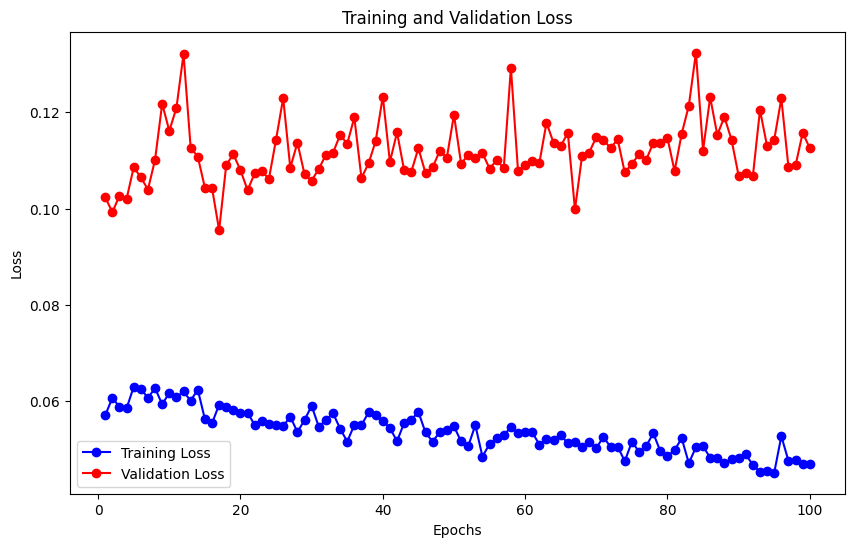

In [65]:
import matplotlib.pyplot as plt

# Assuming you have training and validation losses recorded
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Clear signs of overfitting

In [69]:
tens.shape

torch.Size([19, 128, 128])

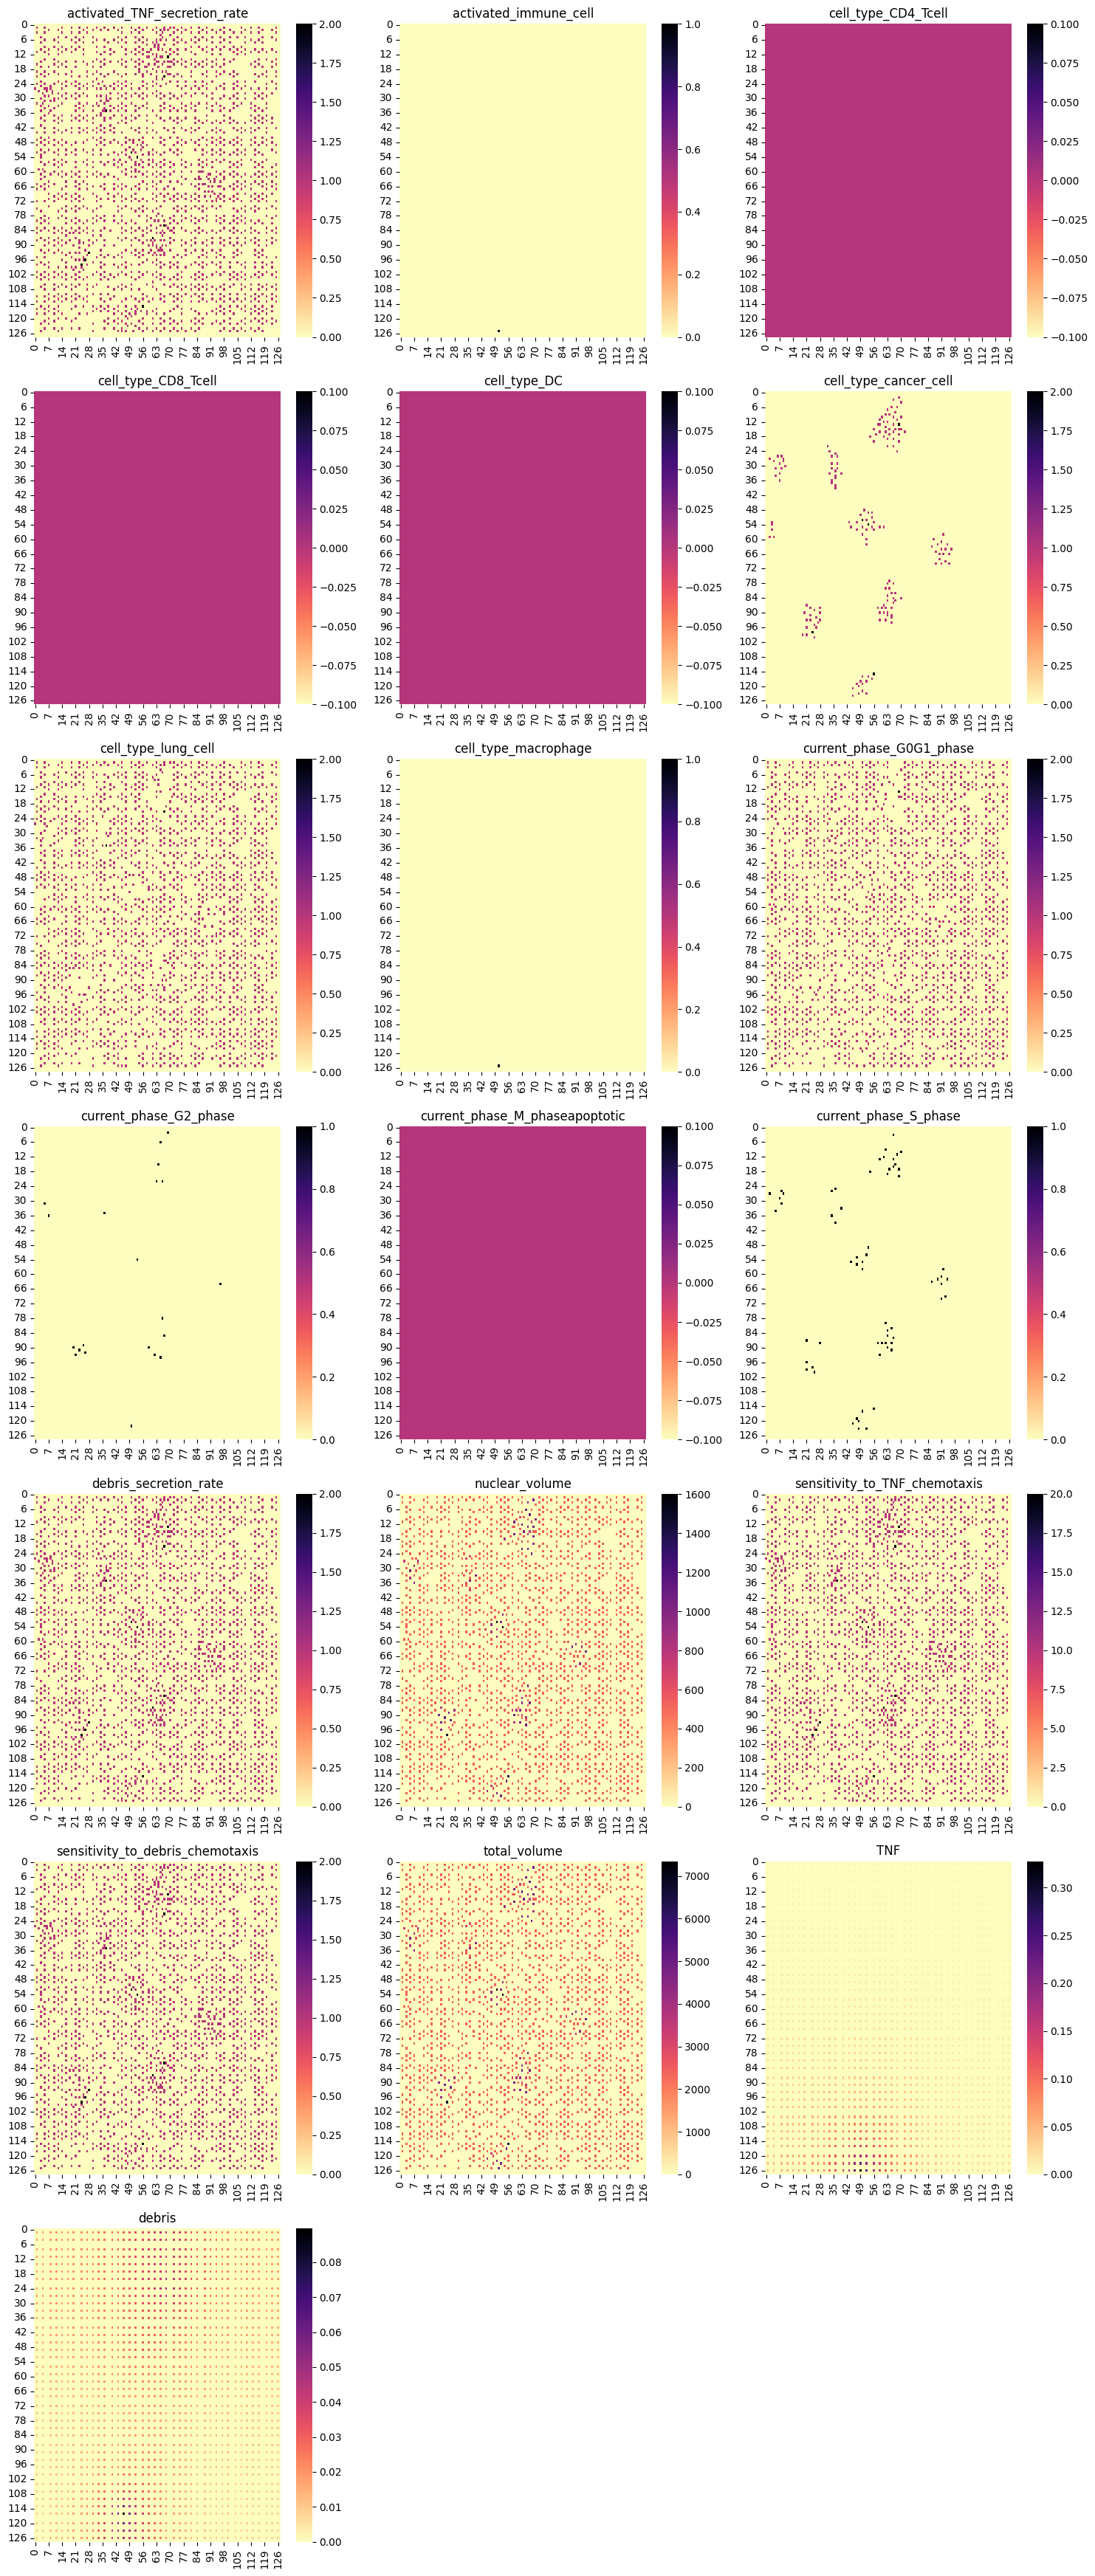

In [71]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example 128x128x6 NumPy array (replace with your actual data)
# idx = range(0, 6)
# data = cell_tens[:, :, idx]
# nms = np.array(varnames)[idx]
tens = data[0]
nms = data_layers

vmin = 0
# Define the number of rows and columns for the facet grid
n_slices = tens.shape[0]
n_cols = 3  # Adjust based on your preference
n_rows = (n_slices + n_cols - 1) // n_cols  # Calculate rows to fit all slices

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration (handle case where there's only one row)
axes = axes.flatten()

# Iterate through slices and plot
for i in range(n_slices):
    sns.heatmap(tens[i, :, :], ax=axes[i], cbar=True, cmap="magma_r", vmin=vmin)
    axes[i].set_title(nms[i])

# Hide any unused subplots
for j in range(n_slices, len(axes)):
    axes[j].axis('off')

# Adjust layout for readability
plt.tight_layout()
plt.show()

In [67]:
data.shape

torch.Size([256, 19, 128, 128])